# Analysis and appliyng Machine Learning on Breast Cancer Dataset

Content:

1. [Pré processamento de Dados](#1)
1. [Aplicando XGBoost](#2)
1. [Utilizando Optuna para Hyperparameter Tuning](#3)
1. [Conclusão](#4)


In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
import sklearn
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold
import optuna
from optuna import Trial, visualization
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Mute warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../input/breast-cancer-wisconsin-data/data.csv')

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


<a id="1"></a> 
# Pré processamento de Dados:

1 - ID number

2 - Diagnosis (M = malignant, B = benign)

3-32 - Ten real-valued features are computed for each cell nucleus:

* a) radius (mean of distances from center to points on the perimeter)
* b) texture (standard deviation of gray-scale values)
* c) perimeter
* d) area
* e) smoothness (local variation in radius lengths)
* f) compactness (perimeter^2 / area - 1.0)
* g) concavity (severity of concave portions of the contour)
* h) concave points (number of concave portions of the contour)
* i) symmetry
* j) fractal dimension ("coastline approximation" - 1)

Não há daldos faltantes, dado pelo concedente do dataset

In [4]:
df.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

Essa coluna unnamed não está declarada nas informações do Dataset, então vou dropá-la, junto com id

In [5]:
df = df.drop(['id','Unnamed: 32'],axis=1)

Por fim, vamos codificar a coluna de diagnóstico:

In [6]:
df['diagnosis'] = df.diagnosis.astype('category').cat.codes

Vamos analisar os tipos de cada coluna:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int8   
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

Ok, tudo certo por aqui, podemos partir para as análises.

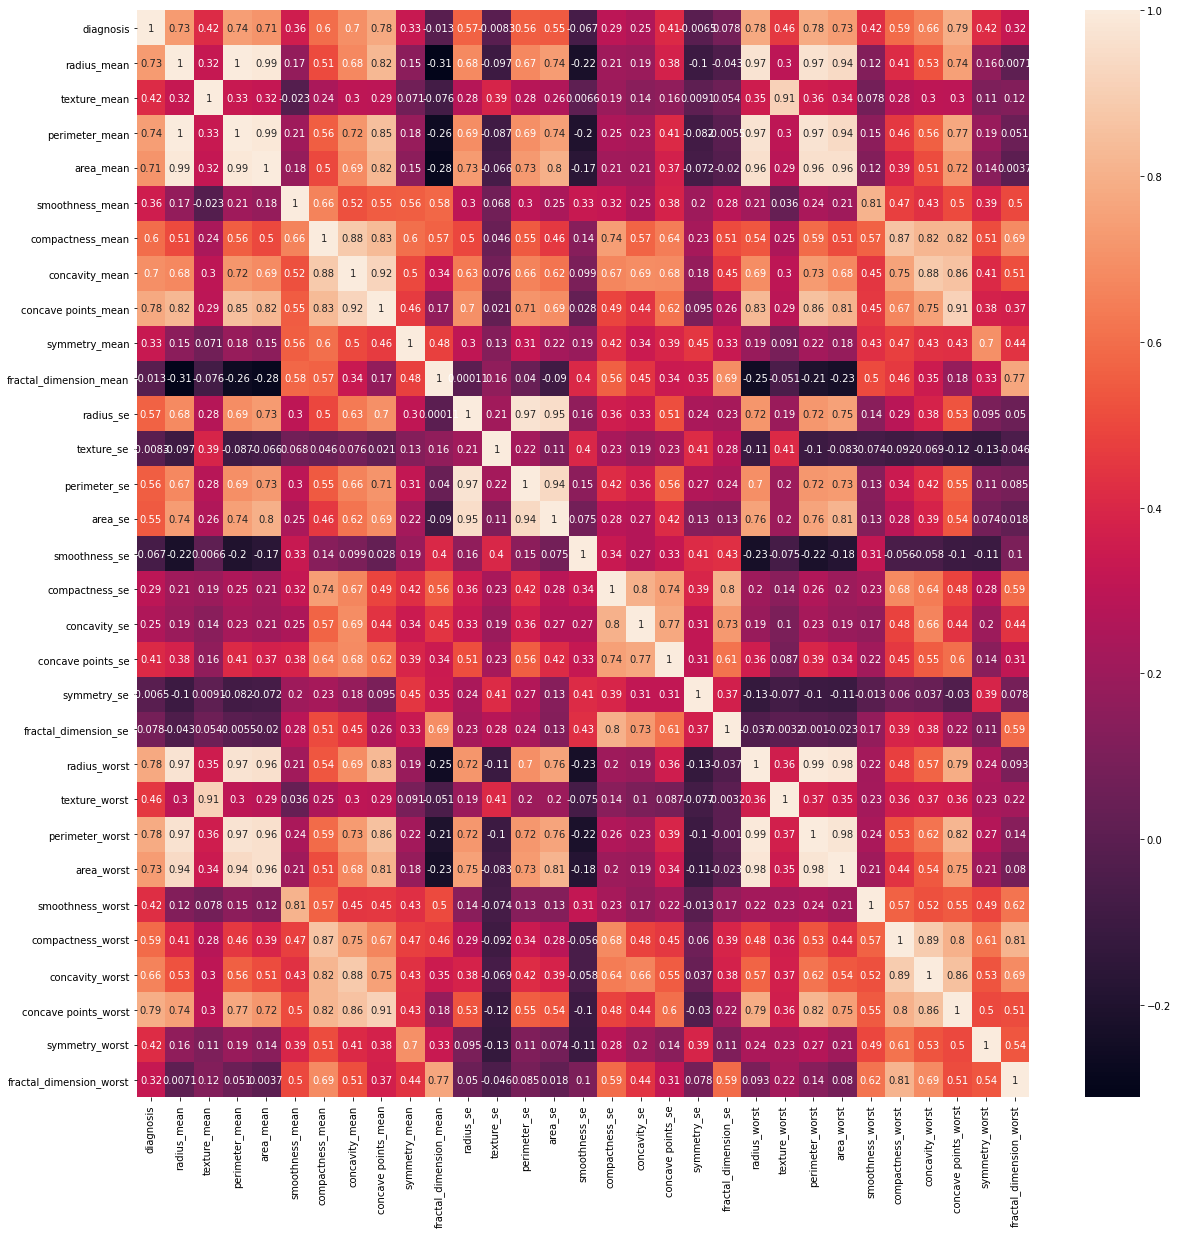

In [8]:
corrMatrix = df.corr()
fig = plt.figure(figsize=(20,20))
sns.heatmap(corrMatrix, annot=True)
plt.show()

Vamos listar a matriz, para vermos os valores:

In [9]:
df.corr()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,1.000000,0.730029,0.415185,0.742636,0.708984,0.358560,0.596534,0.696360,0.776614,0.330499,...,0.776454,0.456903,0.782914,0.733825,0.421465,0.590998,0.659610,0.793566,0.416294,0.323872
radius_mean,0.730029,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.415185,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.742636,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.708984,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.358560,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.596534,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.696360,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.776614,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.330499,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413


Vamos analisar nossa coluna de diagnóstico, para saber se nosso dataset está equilibrado:

Text(0, 0.5, 'Contagem')

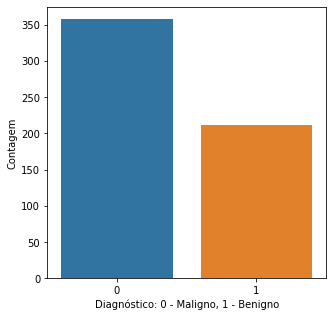

In [10]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x=df.diagnosis,data=df)
plt.xlabel("Diagnóstico: 0 - Maligno, 1 - Benigno")
plt.ylabel("Contagem")

Temos cerca de 75% a mais de dados de malignos, isso pode ser um impecílio depois, nosso modelo pode ter um bias, mas vamos lá!

<a id="2"></a> 
# Aplicando XGBoost

Vamos começar determinando nossas features:

In [11]:
feature_cols = df.columns.values.tolist()
target_col = ['diagnosis']
feature_cols.remove('diagnosis')

In [12]:
# Carregando os dataframes

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Declarando XGBRegressor,
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='binary:logistic')
xgb.fit(X, y)

[20:27:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<a id="3"></a> 
# Utilizando Optuna para Hyperparameter Tuning

In [13]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    
    model = XGBClassifier(objective='binary:logistic')  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [14]:
study = optuna.create_study(direction='minimize', study_name = 'xgbclassifier') 
study.optimize(objective, n_trials=50)

[I 2021-05-13 20:27:56,314] A new study created in memory with name: xgbclassifier
[I 2021-05-13 20:27:56,416] Trial 0 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:56,513] Trial 1 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


[20:27:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-05-13 20:27:56,613] Trial 2 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:56,712] Trial 3 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:56,810] Trial 4 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


[20:27:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-05-13 20:27:56,908] Trial 5 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:57,005] Trial 6 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:57,100] Trial 7 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


[20:27:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-05-13 20:27:57,199] Trial 8 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:57,302] Trial 9 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:57,397] Trial 10 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


[20:27:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-05-13 20:27:57,495] Trial 11 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:57,589] Trial 12 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:57,683] Trial 13 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


[20:27:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-05-13 20:27:57,800] Trial 14 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:57,897] Trial 15 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:57,998] Trial 16 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


[20:27:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

[I 2021-05-13 20:27:58,101] Trial 17 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:58,193] Trial 18 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.



[20:27:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-05-13 20:27:58,291] Trial 19 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:58,388] Trial 20 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:58,487] Trial 21 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


[20:27:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

[I 2021-05-13 20:27:58,592] Trial 22 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:58,686] Trial 23 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.



[20:27:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-05-13 20:27:58,784] Trial 24 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:58,879] Trial 25 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:58,978] Trial 26 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


[20:27:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-05-13 20:27:59,075] Trial 27 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:59,170] Trial 28 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:59,266] Trial 29 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


[20:27:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-05-13 20:27:59,365] Trial 30 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:59,460] Trial 31 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:59,556] Trial 32 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


[20:27:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-05-13 20:27:59,653] Trial 33 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:59,751] Trial 34 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:27:59,847] Trial 35 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


[20:27:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-05-13 20:27:59,945] Trial 36 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:28:00,043] Trial 37 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:28:00,139] Trial 38 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


[20:27:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-05-13 20:28:00,238] Trial 39 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:28:00,330] Trial 40 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:28:00,424] Trial 41 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


[20:28:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-05-13 20:28:00,521] Trial 42 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:28:00,616] Trial 43 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:28:00,708] Trial 44 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


[20:28:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

[I 2021-05-13 20:28:00,831] Trial 45 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.



[20:28:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-05-13 20:28:00,998] Trial 46 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:28:01,094] Trial 47 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.
[I 2021-05-13 20:28:01,187] Trial 48 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


[20:28:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-05-13 20:28:01,282] Trial 49 finished with value: 0.1867718419094071 and parameters: {}. Best is trial 0 with value: 0.1867718419094071.


In [15]:
study.best_params

{}

In [16]:
#fmodel = XGBClassifier(**study.best_params,tree_method='gpu_hist', use_label_encoder=False)
fmodel = XGBClassifier(**study.best_params, use_label_encoder=False)
fmodel.fit(X, y)

[20:28:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Agora, vamos determinar o score do nosso modelo:

In [17]:
# Declarando nosso split de teste e validacao

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state=2)

In [18]:
from sklearn.model_selection import cross_val_score

cross_val_score(fmodel, X, y, scoring='accuracy')

[20:28:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

array([0.97368421, 0.95614035, 0.99122807, 0.98245614, 0.98230088])

<a id="4"></a> 
# Conclusão
* Quaisquer dúvidas, responderei vide comentário ou email
* Recomendações e gratificações são sempre bem-vindas!
* Um abraço!

***Obrigado pelo seu tempo,***
***Lucas Silva***